In [0]:
import matplotlib.pyplot as plt
import lxml
from lxml import etree
import numpy as np
import os
from skimage import io
from skimage.transform import resize
from time import time
from keras.layers import Conv2D, BatchNormalization,MaxPooling2D, UpSampling2D, Input, InputLayer, Dense, Flatten, LeakyReLU, Dropout, Activation, Conv2DTranspose, \
concatenate
from keras import applications, regularizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, BaseLogger, TensorBoard
from keras.models import Model, Sequential
from keras.losses import categorical_crossentropy
from sklearn import decomposition
from keras.utils import plot_model
from sklearn.manifold import TSNE
import matplotlib
import keras.backend as K

Using TensorFlow backend.


## Mount drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Load data

In [0]:
x_train = np.load('drive/My Drive/Colab Notebooks/CV/x_train_data.npy')
x_val = np.load('drive/My Drive/Colab Notebooks/CV/x_val_data.npy')
y_train = np.load('drive/My Drive/Colab Notebooks/CV/y_train_data.npy')
y_val = np.load('drive/My Drive/Colab Notebooks/CV/y_val_data.npy')

In [0]:
x_train_seg = np.load('drive/My Drive/Colab Notebooks/CV/x_train_seg_data.npy')
x_val_seg = np.load('drive/My Drive/Colab Notebooks/CV/x_val_seg_data.npy')
y_train_seg = np.load('drive/My Drive/Colab Notebooks/CV/y_train_seg_data.npy')
y_val_seg = np.load('drive/My Drive/Colab Notebooks/CV/y_val_seg_data.npy')

In [0]:
y_train_labels = [np.where(row==1)[0][0] for row in y_train]
y_val_labels = [np.where(row==1)[0][0] for row in y_val]

## Visualization

In [0]:
colors = ['red','green','blue','purple']
categories = ['aeroplane', 'horse', 'bicycle', 'cat']

In [0]:
def plot_many_vs_reconstructed(original, reconstructed, n=10):
    plt.figure(figsize=(12,4))
    n = [2,n]
    for i in range(n[1]):
        idx = np.random.randint(0, original.shape[0]-1)
        plt.subplot(n[0], n[1], i+1)
        plt.imshow(original[idx,:,:,:])
        plt.axis('off')
        plt.subplot(n[0], n[1], i+1+n[1])
        plt.imshow(reconstructed[idx,:,:,:])
        plt.axis('off')
    plt.show()

In [0]:
def plot_many_vs_reconstructed_seg(original, bw, reconstructed, n=10):
    plt.figure()
    n = [3,n]
    for i in range(n[1]):
        idx = np.random.randint(0, bw.shape[0]-1)
        plt.subplot(n[0], n[1], i+1)
        plt.imshow(original[idx,:,:,:])
        plt.axis('off')       
        plt.subplot(n[0], n[1], i+1+n[1])
        plt.imshow(np.reshape(bw[idx], (128,128)), cmap ='gray')
        plt.axis('off')
        plt.subplot(n[0], n[1], i+1+2*n[1])
        plt.imshow(np.reshape(reconstructed[idx,:,:,:], (128,128)), cmap ='gray')
        plt.axis('off')
    plt.show()

In [0]:
def plot_scatter(arr_x,  labels, xlim, ylim):
    plt.figure()
    plt.xlim(xlim)
    plt.ylim(ylim)
    for i in range(4):
        plt.scatter(arr_x[np.where(np.array(labels)==i)[0],0], arr_x[np.where(np.array(labels)==i)[0],1], c=colors[i], label=categories[i])
    plt.legend(loc='lower right')
    plt.show()

## PCA

In [0]:
x_train_flat = [row.flatten() for row in x_train]
pca = decomposition.PCA(n_components=2)
pca_transformed = pca.fit_transform(x_train_flat)

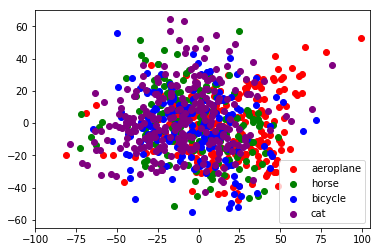

In [0]:
plot_scatter(pca_transformed, y_train_labels, [-100,105], [-65, 70])

## Linear autoencoder approximating PCA

In [0]:
x_train_flat = np.array(x_train_flat)
x_val_flat = np.array([row.flatten() for row in x_val])
input_dim = x_train_flat.shape[1]
encoding_dim = 2  
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='linear')(input_img)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder_pca = Model(input_img, decoded)
autoencoder_pca.compile(optimizer='adam', loss='mse')
print(autoencoder_pca.summary())

history = autoencoder_pca.fit(x=x_train_flat, y=x_train_flat, epochs=100, validation_data=[x_val_flat, x_val_flat], batch_size=16)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 49152)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 98306     
_________________________________________________________________
dense_2 (Dense)              (None, 49152)             147456    
Total params: 245,762
Trainable params: 245,762
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 795 samples, validate on 831 samples
Epoch 1/100
795/795 [==============================] - 3s 4ms/step - loss: 0.0943 - val_loss: 0.0519
Epoch 2/100
795/795 [==============================] - 1s 819us/step - loss: 0.0512 - val_loss: 0.0449
Epoch 3/100
795/795 [====

In [0]:
encoder_pca = Model(input_img, encoded)
encoded_input_pca = Input(shape=(encoding_dim,))
decoder_layer_pca = autoencoder_pca.layers[-1]
decoder_pca = Model(encoded_input_pca, decoder_layer_pca(encoded_input_pca))
encoded_data_pca = encoder_pca.predict(x_train_flat)

plot_scatter(encoded_data_pca, y_train_labels, [-50,5], [-30, 25])

> using a linearly activated autoencoder (AE) to approximate principal component analysis (PCA). From a math point of view, minimizing the reconstruction error in PCA is the same as AE

> Encoder part will be equivalent to PCA if linear encoder, linear decoder, square error loss function with normalized inputs are used.



> PCA is restricted to a linear map, while auto encoders can have nonlinear enoder/decoders. A single layer auto encoder with linear transfer function is nearly equivalent to PCA, where nearly means that the W
found by AE and PCA won't be the same--but the subspace spanned by the respective W's will.






## Convolutional autoencoder

In [0]:
class ConvAutoEncoder:

    def __init__(self, input_shape, optimizer="adam", lossfn="mse"):
        # For now, assuming input_shape is mxnxc, and m,n are multiples of 4.

        self.input_shape = input_shape
        
        # define encoder architecture
        self.encoder = Sequential()
        self.encoder.add(InputLayer(input_shape))
        self.encoder.add(Conv2D(128, (2,2), activation='relu', padding='same'))
        self.encoder.add(BatchNormalization())
        self.encoder.add(Conv2D(64, (2,2), activation='relu', padding='same'))
        self.encoder.add(BatchNormalization())
        self.encoder.add(MaxPooling2D(pool_size=(2,2))) #14 x 14 x 32
        self.encoder.add(Conv2D(32, (2,2), activation='relu', padding='same')) #14 x 14 x 64
        self.encoder.add(BatchNormalization())
        self.encoder.add(MaxPooling2D(pool_size=(2, 2))) #7 x 7 x 64
        self.encoder.add(Conv2D(32, (2,2), activation='relu', padding='same')) #7 x 7 x 128 (small and thick)
        self.encoder.add(BatchNormalization())
        self.encoder.add(MaxPooling2D(pool_size=(2, 2))) 
                         
        self.decoder = Sequential()     
        self.decoder.add(Conv2D(32, (2,2), activation='relu', padding='same')) 
        self.decoder.add(BatchNormalization())
        self.decoder.add(UpSampling2D((2,2)))
        self.decoder.add(Conv2D(32, (2,2), activation='relu', padding='same'))
        self.decoder.add(BatchNormalization())
        self.decoder.add(UpSampling2D((2,2)))
        self.decoder.add(Conv2D(64, (2,2), activation='relu', padding='same')) 
        self.decoder.add(BatchNormalization())
        self.decoder.add(Conv2D(128, (2,2), activation='relu', padding='same')) 
        self.decoder.add(BatchNormalization())
        self.decoder.add(UpSampling2D((2,2)))
        self.decoder.add(Conv2D(3, (2,2), activation='relu', padding='same'))
        
        input_i = Input(input_shape)
        code = self.encoder(input_i)
        reconstructed = self.decoder(code)
        self.ae = Model(inputs=input_i, outputs=reconstructed)
        self.ae.compile(optimizer=optimizer, loss=lossfn)


    def fit(self, train, test, epochs=25, callbacks=[BaseLogger()], batch=16):

        tb = TensorBoard(log_dir="logs/{}".format(time()))
#         tbc=TensorBoardColab()
        
        tb.set_model(self.ae)
        reduce_lr =ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                      patience=10, min_lr=0.000001)
        self.ae.fit(x=train, y=train, epochs=epochs, validation_data=[test, test],
                    callbacks=[BaseLogger(), tb, reduce_lr], batch_size=batch)

        self.mse = self.ae.evaluate(test, test)
        self.mse_train = self.ae.evaluate(train, train)
        print('CAE MSE on validation data: ', self.mse)
        print('CAE MSE on train data: ', self.mse_train)
    
    def fit_aug(self, train, test, epochs=25, callbacks=[BaseLogger()], batch=16):
        tb = TensorBoard(log_dir="logs/{}".format(time()))
        tb.set_model(self.ae)
        reduce_lr =ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                      patience=10, min_lr=0.000001)
        
        datagen = ImageDataGenerator(rescale=1./255, rotation_range=360, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
        valid_datagen = ImageDataGenerator(rescale=1./255)

        self.ae.fit_generator(datagen.flow(train, train, batch_size=16), steps_per_epoch=len(train) / 16, validation_data=(test, test), epochs=100,
                    callbacks=[BaseLogger(), tb, reduce_lr])

        self.mse = self.ae.evaluate(test, test)
        print('CAE MSE on validation data: ', self.mse)
       
    
    def save_weights(self, path=None, prefix=""):
        if path is None: path = os.getcwd()
        self.encoder.save_weights(os.path.join(path, prefix + "encoder_weights.h5"))
        self.decoder.save_weights(os.path.join(path, prefix + "decoder_weights.h5"))


    def load_weights(self, path=None, prefix=""):
        if path is None: path = os.getcwd()
        self.encoder.load_weights(os.path.join(path, prefix + "encoder_weights.h5"))
        self.decoder.load_weights(os.path.join(path, prefix + "decoder_weights.h5"))


    def encode(self, input):
        return self.encoder.predict(input)

    
    def decode(self, codes):
        return self.decoder.predict(codes)
    
    def get_encoder(self):
        self.load_weights()
        return self.encoder
    
    def get_decoder(self):
        self.load_weights()
        return self.decoder

In [0]:
cae = ConvAutoEncoder(input_shape=(x_train.shape[1], x_train.shape[2], 3), optimizer = RMSprop(lr=0.001))
cae.encoder.summary()
cae.fit(x_train, x_val, epochs=100, batch=16)
cae.save_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 128)     1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      32832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        8224      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 32)        128       
__________

In [0]:
plot_model(cae.encoder, to_file='model_enc.png')
plot_model(cae.decoder, to_file='model_dec.png')

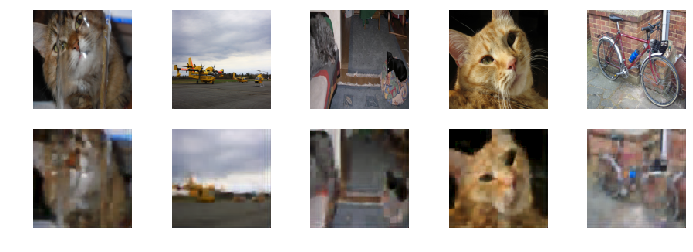

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


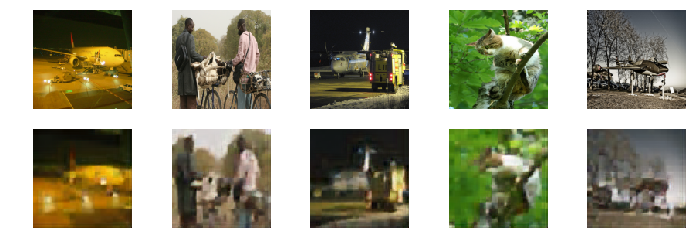

In [0]:
en_val = cae.encode(x_val)
dec_val = cae.decode(en_val)
en_train = cae.encode(x_train)
dec_train= cae.decode(en_train)
plot_many_vs_reconstructed(x_train, dec_train, n=5)
plot_many_vs_reconstructed(x_val, dec_val, n=5)

In [0]:
def get_tsne(data, ncom, mod):
    codes = mod.encode(data)
    codes = [row.flatten() for row in codes]
    codes_embedded = TSNE(n_components=2).fit_transform(codes)
    return codes_embedded

In [0]:
def get_tsne2(data, ncom, mod):
    codes = mod.predict(data)
    codes = [row.flatten() for row in codes]
    codes_embedded = TSNE(n_components=2).fit_transform(codes)
    return codes_embedded

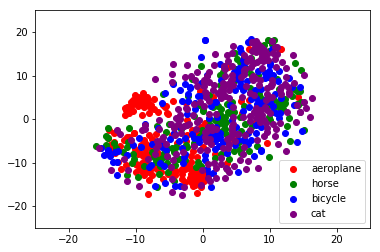

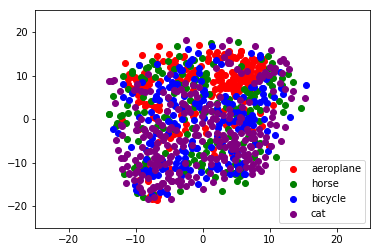

In [0]:
train_codes_embedded = get_tsne(x_train, 2, cae)
val_codes_embedded = get_tsne(x_val, 2, cae)

plot_scatter(train_codes_embedded, y_train_labels, [-25, 25], [-25, 25])
plot_scatter(val_codes_embedded, y_val_labels, [-25, 25], [-25, 25])

## Classification

In [0]:
def fully_connected(encoded):
    
    fully_conn_model = Sequential()
    fully_conn_model.add(Flatten())
    
    fully_conn_model.add(Dense(256))
    fully_conn_model.add(LeakyReLU(alpha=0.3))
    
    fully_conn_model.add(Dropout(0.5))
    fully_conn_model.add(Dense(64))
    fully_conn_model.add(LeakyReLU(alpha=0.3))

    fully_conn_model.add(Dropout(0.5))

    
    fully_conn_model.add(Dense(16))
    fully_conn_model.add(LeakyReLU(alpha=0.3))

    fully_conn_model.add(Dropout(0.5))
    
    fully_conn_model.add(Dense(4, activation='softmax'))
    
    plot_model(fully_conn_model, to_file='full_model.png')
    return fully_conn_model(encoded)

### Training the encoder + fully connected model with pretrained encoder weights and by freezing the encoder weights



In [0]:
input_img = Input(shape = (x_train.shape[1], x_train.shape[2], 3))
encoder = cae.get_encoder()
encode = encoder(input_img)
full_model = Model(input_img,fully_connected(encode))
for layer in full_model.layers[:2]:
    layer.trainable = False
print(full_model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 16, 16, 32)        47872     
_________________________________________________________________
sequential_3 (Sequential)    (None, 4)                 2114964   
Total params: 2,162,836
Trainable params: 2,114,964
Non-trainable params: 47,872
_________________________________________________________________
None


In [0]:
full_model.compile(loss=categorical_crossentropy, optimizer=Adam(),metrics=['accuracy'])
full_model.fit(x_train, y_train, batch_size=32,epochs=100,verbose=1,validation_data=(x_val, y_val))

Train on 795 samples, validate on 831 samples
Epoch 1/100
795/795 [==============================] - 6s 7ms/step - loss: 6.8324 - acc: 0.2931 - val_loss: 3.9455 - val_acc: 0.4862
Epoch 2/100
795/795 [==============================] - 4s 6ms/step - loss: 6.6407 - acc: 0.3975 - val_loss: 4.2567 - val_acc: 0.5162
Epoch 3/100
795/795 [==============================] - 4s 6ms/step - loss: 6.0776 - acc: 0.4252 - val_loss: 3.4427 - val_acc: 0.5114
Epoch 4/100
795/795 [==============================] - 4s 6ms/step - loss: 5.5185 - acc: 0.4113 - val_loss: 2.2739 - val_acc: 0.5523
Epoch 5/100
795/795 [==============================] - 4s 6ms/step - loss: 4.6102 - acc: 0.4868 - val_loss: 2.5247 - val_acc: 0.5535
Epoch 6/100
795/795 [==============================] - 4s 6ms/step - loss: 4.9594 - acc: 0.4428 - val_loss: 2.8698 - val_acc: 0.5572
Epoch 7/100
795/795 [==============================] - 4s 5ms/step - loss: 4.3022 - acc: 0.4629 - val_loss: 2.0055 - val_acc: 0.6005
Epoch 8/100
795/795 [==

### Training the encoder + fully connected model with pretrained encoder weights 

In [0]:
encoder_trainable = cae.get_encoder()
encode_tr = encoder_trainable(input_img)
full_model_trainable = Model(input_img,fully_connected(encode_tr))
for layer in full_model_trainable.layers[:2]:
    layer.trainable = True
print(full_model_trainable.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 16, 16, 32)        47872     
_________________________________________________________________
sequential_4 (Sequential)    (None, 4)                 2114964   
Total params: 2,162,836
Trainable params: 2,162,324
Non-trainable params: 512
_________________________________________________________________
None


In [0]:
full_model_trainable.compile(loss=categorical_crossentropy, optimizer=Adam(),metrics=['accuracy'])
full_model_trainable.fit(x_train, y_train, batch_size=32,epochs=100,verbose=1,validation_data=(x_val, y_val))

Train on 795 samples, validate on 831 samples
Epoch 1/100
795/795 [==============================] - 10s 13ms/step - loss: 5.4968 - acc: 0.3522 - val_loss: 2.2500 - val_acc: 0.4621
Epoch 2/100
795/795 [==============================] - 8s 10ms/step - loss: 5.0321 - acc: 0.3660 - val_loss: 2.8867 - val_acc: 0.4356
Epoch 3/100
795/795 [==============================] - 8s 10ms/step - loss: 3.8400 - acc: 0.4478 - val_loss: 3.2844 - val_acc: 0.5054
Epoch 4/100
795/795 [==============================] - 8s 10ms/step - loss: 3.2943 - acc: 0.4491 - val_loss: 1.5599 - val_acc: 0.5548
Epoch 5/100
795/795 [==============================] - 8s 10ms/step - loss: 2.7264 - acc: 0.4805 - val_loss: 2.3737 - val_acc: 0.4910
Epoch 6/100
795/795 [==============================] - 8s 10ms/step - loss: 2.5118 - acc: 0.4918 - val_loss: 3.6124 - val_acc: 0.5102
Epoch 7/100
795/795 [==============================] - 8s 10ms/step - loss: 2.3553 - acc: 0.5107 - val_loss: 1.7172 - val_acc: 0.6101
Epoch 8/100
795

### Training the encoder + fully connected model with randomly initialized weights

In [0]:
cae2 = ConvAutoEncoder(input_shape=(x_train.shape[1], x_train.shape[2], 3),)
input_img = Input(shape = (x_train.shape[1], x_train.shape[2], 3))
encoder_init = cae2.get_encoder()
encode_init = encoder_init(input_img)
full_model_init = Model(input_img,fully_connected(encode_init))
# for layer in full_model_init.layers[:2]:
#     layer.trainable = True
print(full_model_init.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 16, 16, 32)        47872     
_________________________________________________________________
sequential_7 (Sequential)    (None, 4)                 2114964   
Total params: 2,162,836
Trainable params: 2,162,324
Non-trainable params: 512
_________________________________________________________________
None


In [0]:
full_model_init.compile(loss=categorical_crossentropy, optimizer=Adam(),metrics=['accuracy'])
full_model_init.fit(x_train, y_train, batch_size=32,epochs=100,verbose=1,validation_data=(x_val, y_val))

Train on 795 samples, validate on 831 samples
Epoch 1/100
795/795 [==============================] - 11s 14ms/step - loss: 6.5658 - acc: 0.3459 - val_loss: 4.3817 - val_acc: 0.5054
Epoch 2/100
795/795 [==============================] - 8s 10ms/step - loss: 6.1867 - acc: 0.4528 - val_loss: 3.9264 - val_acc: 0.5078
Epoch 3/100
795/795 [==============================] - 8s 10ms/step - loss: 4.8110 - acc: 0.4566 - val_loss: 4.5989 - val_acc: 0.4501
Epoch 4/100
795/795 [==============================] - 8s 10ms/step - loss: 4.0777 - acc: 0.5182 - val_loss: 3.2812 - val_acc: 0.4440
Epoch 5/100
795/795 [==============================] - 8s 10ms/step - loss: 3.8654 - acc: 0.4767 - val_loss: 3.1074 - val_acc: 0.5211
Epoch 6/100
795/795 [==============================] - 8s 10ms/step - loss: 3.3503 - acc: 0.5132 - val_loss: 2.3328 - val_acc: 0.5860
Epoch 7/100
795/795 [==============================] - 8s 10ms/step - loss: 2.7485 - acc: 0.5220 - val_loss: 4.0101 - val_acc: 0.4513
Epoch 8/100
795

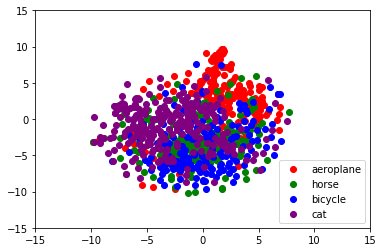

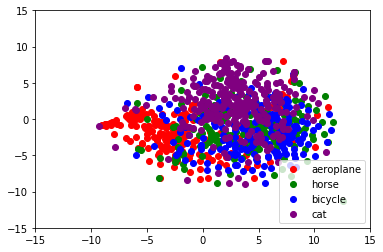

In [0]:
train_codes_embedded = get_tsne(x_train, 2, cae)
val_codes_embedded = get_tsne(x_val, 2, cae)

plot_scatter(train_codes_embedded, y_train_labels, [-15, 15], [-15, 15])
plot_scatter(val_codes_embedded, y_val_labels, [-15, 15], [-15, 15])

### Training the autoencoder and encoder-classifier together

In [0]:
cae3 = ConvAutoEncoder(input_shape=(x_train.shape[1], x_train.shape[2], 3), optimizer = RMSprop(lr=0.001))

encoder_bi = cae3.get_encoder()
decoder_bi = cae3.get_decoder()


input_img = Input(shape = (x_train.shape[1], x_train.shape[2], 3))

encode_bi = encoder_bi(input_img)
full_model_bi = Model(input_img,fully_connected(encode_bi))
ae_bi = Model(input_img, decoder_bi(encode_bi))

# print(ae_bi.summary())
# print(full_model_bi.summary())
ae_bi.compile(optimizer=Adam(), loss='mse')
full_model_bi.compile(loss=categorical_crossentropy, optimizer=Adam(),metrics=['accuracy'])

In [0]:
b_size = 32
for e in range(100):
#     if e%10 ==0:
#         print(e)
    for b in range(25):
        batch_indices = np.random.randint(low=0, high=795, size=b_size)
        x_train_crop = np.array([x_train[i, :] for i in batch_indices])
        y_train_crop = np.array([y_train[i, :] for i in batch_indices])
        
        ae_bi.train_on_batch(x=x_train_crop, y=x_train_crop)
        full_model_bi.train_on_batch(x=x_train_crop, y=y_train_crop)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


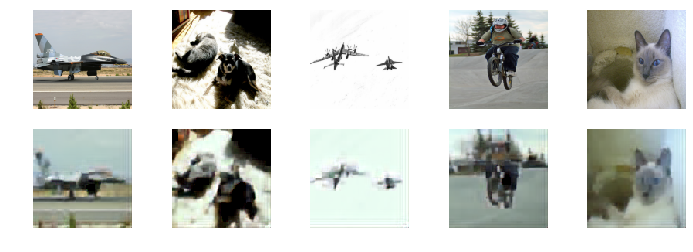

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


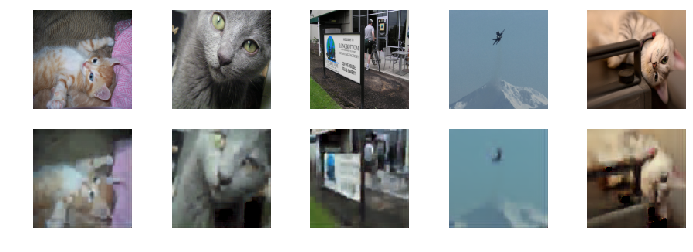

In [0]:
dec_val_bi = ae_bi.predict(x_val)
dec_train_bi = ae_bi.predict(x_train)

plot_many_vs_reconstructed(x_train, dec_train_bi, n=5)
plot_many_vs_reconstructed(x_val, dec_val_bi, n=5)

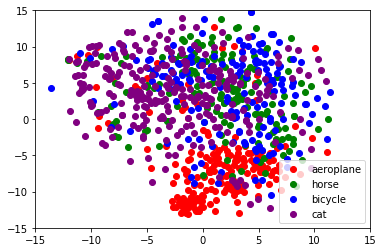

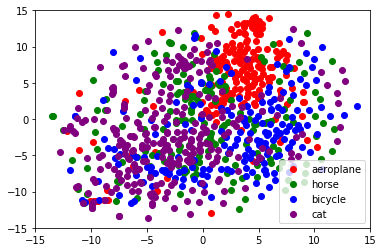

In [0]:
train_codes_embedded = get_tsne(x_train, 2, cae3)
val_codes_embedded = get_tsne(x_val, 2, cae3)

plot_scatter(train_codes_embedded, y_train_labels, [-15, 15], [-15, 15])
plot_scatter(val_codes_embedded, y_val_labels, [-15, 15], [-15, 15])

In [0]:
print(full_model_bi.evaluate(x=x_train, y=y_train))
print(full_model_bi.evaluate(x=x_val, y=y_val))

795/795 [==============================] - 3s 4ms/step
[0.02791171265645239, 0.9987421383647799]
831/831 [==============================] - 2s 3ms/step
[2.6640519321179994, 0.6377857993799569]


### Transfer learning

In [0]:
input_i = Input((128,128,3))
vgg_model = applications.VGG16(weights='imagenet', include_top=False)
x = vgg_model(input_i)
x = Flatten()(x)

x = Dense(128, activation='relu' )(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

58892288/58889256 [==============================] - 3s 0us/step


In [0]:
model = Model(inputs=input_i, outputs=predictions)

for layer in vgg_model.layers:
    layer.trainable = False
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 516       
Total params: 15,763,908
Trainable params: 1,049,220
Non-trainable params: 14,714,688
________________________________________________________

In [0]:
model.fit(x_train, y_train, epochs=15, validation_data=(x_val, y_val), verbose=1)

Train on 795 samples, validate on 831 samples
Epoch 1/15
795/795 [==============================] - 12s 16ms/step - loss: 1.1957 - acc: 0.5887 - val_loss: 0.6353 - val_acc: 0.7569
Epoch 2/15
795/795 [==============================] - 5s 6ms/step - loss: 0.5050 - acc: 0.8239 - val_loss: 0.5019 - val_acc: 0.8171
Epoch 3/15
795/795 [==============================] - 5s 6ms/step - loss: 0.4061 - acc: 0.8541 - val_loss: 0.5030 - val_acc: 0.8267
Epoch 4/15
795/795 [==============================] - 5s 6ms/step - loss: 0.3116 - acc: 0.8969 - val_loss: 0.5220 - val_acc: 0.8135
Epoch 5/15
795/795 [==============================] - 5s 6ms/step - loss: 0.2482 - acc: 0.9208 - val_loss: 0.4872 - val_acc: 0.8051
Epoch 6/15
795/795 [==============================] - 5s 6ms/step - loss: 0.1945 - acc: 0.9346 - val_loss: 0.4752 - val_acc: 0.8267
Epoch 7/15
795/795 [==============================] - 5s 6ms/step - loss: 0.1218 - acc: 0.9635 - val_loss: 0.5332 - val_acc: 0.8111
Epoch 8/15
795/795 [========

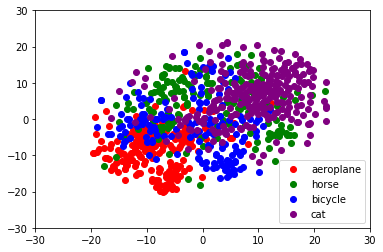

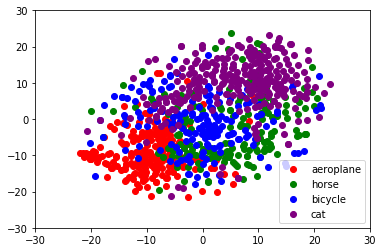

In [0]:
train_codes_embedded = get_tsne2(x_train, 2, vgg_model)
val_codes_embedded = get_tsne2(x_val, 2, vgg_model)

plot_scatter(train_codes_embedded, y_train_labels, [-30, 30], [-30, 30])
plot_scatter(val_codes_embedded, y_val_labels,[-30, 30], [-30, 30])

## Segmentation

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
    padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
    padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
# contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
input_img = Input((128,128, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 128, 128, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, 128, 128, 16) 64          conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 128, 16) 0           batch_normalization_43[0][0]     
__________________________________________________________________________________________________
conv2d_48 

In [0]:
results = model.fit(x_train_seg, np.reshape(y_train_seg, (91,128,128,1)), batch_size=32, epochs=100, validation_data=(x_val_seg, np.reshape(y_val_seg,(104,128,128,1))))

Train on 91 samples, validate on 104 samples
Epoch 1/100
91/91 [==============================] - 12s 135ms/step - loss: 0.6423 - acc: 0.7223 - val_loss: 0.5492 - val_acc: 0.7684
Epoch 2/100
91/91 [==============================] - 1s 11ms/step - loss: 0.5452 - acc: 0.7342 - val_loss: 0.5443 - val_acc: 0.7511
Epoch 3/100
91/91 [==============================] - 1s 11ms/step - loss: 0.5046 - acc: 0.7454 - val_loss: 0.5215 - val_acc: 0.7290
Epoch 4/100
91/91 [==============================] - 1s 11ms/step - loss: 0.4587 - acc: 0.7771 - val_loss: 0.6017 - val_acc: 0.7256
Epoch 5/100
91/91 [==============================] - 1s 11ms/step - loss: 0.4016 - acc: 0.8176 - val_loss: 0.9067 - val_acc: 0.7196
Epoch 6/100
91/91 [==============================] - 1s 11ms/step - loss: 0.3729 - acc: 0.8375 - val_loss: 1.1349 - val_acc: 0.7557
Epoch 7/100
91/91 [==============================] - 1s 11ms/step - loss: 0.3372 - acc: 0.8549 - val_loss: 1.7694 - val_acc: 0.7144
Epoch 8/100
91/91 [==========

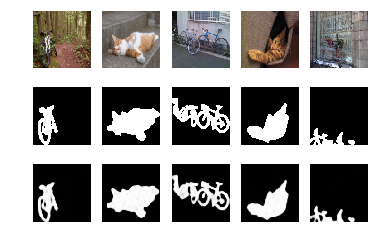

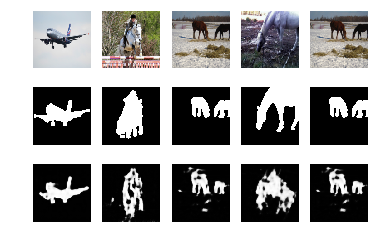

In [0]:
val_segmented = model.predict(x_val_seg)
train_segmented = model.predict(x_train_seg)

plot_many_vs_reconstructed_seg(x_train_seg,y_train_seg,train_segmented, n=5)
plot_many_vs_reconstructed_seg(x_val_seg, y_val_seg, val_segmented, n=5)

In [0]:
def calc_dice(x_train_seg, y_train_seg, model):
    dices = []
    pred = model.predict(x_train_seg)
    for i in range(len(x_train_seg)):
        x_v=np.reshape(y_train_seg[i], (128,128))
        pr = np.reshape(pred[i,:,:,:], (128,128))
        dice = np.sum(pr[x_v==1])*2.0 / (np.sum(pr) + np.sum(x_v))
        dices.append(dice)
    dice = np.mean(np.array(dices))
    print('Dice similarity score is {}'.format(dice))
    
    return dice

In [0]:
dice_train = calc_dice(x_train_seg, y_train_seg, model)

dice_val = calc_dice(x_val_seg, y_val_seg, model)

Dice similarity score is 0.9340657531257237
Dice similarity score is 0.5813318532048053


In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [0]:
input_img = Input((128,128, 3), name='img')
model_dice = get_unet(input_img, n_filters=16, dropout=0, batchnorm=True)
model_dice.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=[dice_coef])
model_dice.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 128, 128, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 128, 128, 16) 64          conv2d_66[0][0]                  
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 128, 128, 16) 0           batch_normalization_61[0][0]     
__________________________________________________________________________________________________
conv2d_67 

In [0]:
results_dice = model_dice.fit(x_train_seg, y_train_seg, batch_size=32, epochs=150, validation_data=(x_val_seg, y_val_seg))

Train on 91 samples, validate on 104 samples
Epoch 1/150
91/91 [==============================] - 13s 140ms/step - loss: -0.3696 - dice_coef: 0.3696 - val_loss: -0.3687 - val_dice_coef: 0.3687
Epoch 2/150
91/91 [==============================] - 1s 10ms/step - loss: -0.4176 - dice_coef: 0.4176 - val_loss: -0.4103 - val_dice_coef: 0.4103
Epoch 3/150
91/91 [==============================] - 1s 11ms/step - loss: -0.4566 - dice_coef: 0.4566 - val_loss: -0.4245 - val_dice_coef: 0.4245
Epoch 4/150
91/91 [==============================] - 1s 10ms/step - loss: -0.5011 - dice_coef: 0.5011 - val_loss: -0.3898 - val_dice_coef: 0.3898
Epoch 5/150
91/91 [==============================] - 1s 10ms/step - loss: -0.5367 - dice_coef: 0.5367 - val_loss: -0.4568 - val_dice_coef: 0.4568
Epoch 6/150
91/91 [==============================] - 1s 10ms/step - loss: -0.5718 - dice_coef: 0.5718 - val_loss: -0.4408 - val_dice_coef: 0.4408
Epoch 7/150
91/91 [==============================] - 1s 11ms/step - loss: -0.

In [0]:
dice_train = calc_dice(x_train_seg, y_train_seg, model_dice)

dice_val = calc_dice(x_val_seg, y_val_seg, model_dice)

Dice similarity score is 0.9758988268758559
Dice similarity score is 0.6131827286268055
